# The Python Almanac

The world of Python packages is adventurous and can be confusing at times.
Here, I try to aggregate and showcase a diverse set of Python packages which have become useful at some point.

## Introduction

### Installing Python

Normally you should use your system's package manager.
In case of problems, try [pyenv](https://github.com/pyenv/pyenv):

```bash
$ pyenv versions
$ pyenv install <foo>
$ pyenv global <foo>
```

This will install the specified Python version to `$(pyenv root)/versions`.

### Installing packages

Python packages can be easily installed from [PyPI (Python Package Index)](https://pypi.org/):

```bash
$ pip install --user <package> (local install does not clash with system packages)
```

Using `--user` will install the package only for the current user. This is good if multiple users need different package versions, but can lead to redundant installations.

To install from a git repository, use the following command:

```bash
$ pip install --user -U git+https://github.com/<user>/<repository>@<branch>
```

### Package management

While packages can be installed globally or user-specific, it often makes sense to create project-specific virtual environments.

This can be easily accomplished using [venv](https://docs.python.org/3/library/venv.html):

```bash
$ python -m venv my_venv
$ . venv/bin/activate
$ pip install <package>
```

## Software development

### Package Distribution

Use `setuptools`.
[poetry](https://github.com/sdispater/poetry) handles many otherwise slightly annoying things:
```
$ poetry init/add/install/run/publish
```

CI encapsulation: [tox](https://github.com/tox-dev/tox).

Keeping track of version numbers can be achieved using [bump2version](https://github.com/c4urself/bump2version).

Transform between various project file formats using [dephell](https://github.com/dephell/dephell).

### Testing

Setup testing using [pytest](https://github.com/pytest-dev/pytest). It has a wide range of useful features, such as fixtures (modularized per-test setup code) and test parametrization (quickly execute the same test for multiple inputs).

In [1]:
%%writefile /tmp/tests.py

import os
import pytest


@pytest.fixture(scope='session')
def custom_directory(tmp_path_factory):
    return tmp_path_factory.mktemp('workflow_test')


def test_fixture_execution(custom_directory):
    assert os.path.isdir(custom_directory)


@pytest.mark.parametrize('expression_str,result', [
    ('2+2', 4), ('2*2', 4), ('2**2', 4)
])
def test_expression_evaluation(expression_str, result):
    assert eval(expression_str) == result

Writing /tmp/tests.py


In [2]:
!pytest -v /tmp/tests.py

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.2, py-1.10.0, pluggy-0.13.1 -- /Users/kimja/.pyenv/versions/3.8.6/bin/python3.8
cachedir: .pytest_cache
rootdir: /tmp
plugins: anyio-2.0.2
collecting ... 

collected 4 items                                                              

../../../../../../../../tmp/tests.py::test_fixture_execution PASSED      [ 25%]
../../../../../../../../tmp/tests.py::test_expression_evaluation[2+2-4] PASSED [ 50%]
../../../../../../../../tmp/tests.py::test_expression_evaluation[2*2-4] PASSED [ 75%]
../../../../../../../../tmp/tests.py::test_expression_evaluation[2**2-4] PASSED [100%]

============================== 4 passed in 0.03s ===============================


### Linting/Formatting

Linters and code formatters improve the quality of your Python code by conducting a static analysis and flagging issues.

* [flake8](https://github.com/PyCQA/flake8): Catch various common errors and adhere to PEP8. Supports many [plugins](https://github.com/DmytroLitvinov/awesome-flake8-extensions).
* [pylint](https://github.com/PyCQA/pylint): Looks for even more sources of code smell.
* [black](https://github.com/psf/black): "*the* uncompromising Python code formatter".

While there can be a considerable overlap between the tools' outputs, each offers its own advantages and they can typically be used together.

### Profiling

Code profiling tools are a great way of finding parts of your code which can be optimized.
They come in various flavors:

* [line_profiler](https://github.com/pyutils/line_profiler): which parts of the code require most execution time
* [memory_profiler](https://github.com/pythonprofilers/memory_profiler): which parts of the code consume the most memory

Consider the following script (note the `@profile` decorator):

In [3]:
%%writefile /tmp/script.py

@profile
def main():
    # takes a long time
    for _ in range(100_000):
        1337**42

    # requires a lot of memory
    arr = [1] * 1_000_000
    
main()

Writing /tmp/script.py


#### line_profiler

In [4]:
!kernprof -l -v -o /tmp/script.py.lprof /tmp/script.py

Wrote profile results to /tmp/script.py.lprof
Timer unit: 1e-06 s

Total time: 0.13024 s
File: /tmp/script.py
Function: main at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile
     3                                           def main():
     4                                               # takes a long time
     5    100001      33213.0      0.3     25.5      for _ in range(100_000):
     6    100000      93762.0      0.9     72.0          1337**42
     7                                           
     8                                               # requires a lot of memory
     9         1       3265.0   3265.0      2.5      arr = [1] * 1_000_000



#### memory_profiler

In [5]:
!python3 -m memory_profiler /tmp/script.py

Filename: /tmp/script.py

Line #    Mem usage    Increment  Occurences   Line Contents
     2   37.668 MiB   37.668 MiB           1   @profile
     3                                         def main():
     4                                             # takes a long time
     5   37.668 MiB    0.000 MiB      100001       for _ in range(100_000):
     6   37.668 MiB    0.000 MiB      100000           1337**42
     7                                         
     8                                             # requires a lot of memory
     9   45.301 MiB    7.633 MiB           1       arr = [1] * 1_000_000




### Debugging

#### Raw python

[ipdb](https://github.com/gotcha/ipdb) is useful Python commandline debugger.
To invoke it, simply put `import ipdb; ipdb.set_trace()` in your code.
Starting with Python 3.7, you can also write `breakpoint()`. This honors the `PYTHONBREAKPOINT` environment variable.
To automatically start the debugger when an error occurs, run your script with `python -m ipdb -c continue <script>`.

The debugger supports various commands:
* p: print expression
* pp: pretty print
* n: next line in current function
* s: execute current line and stop at next possible location (e.g. in function call)
* c: continue execution
* unt: execute until we reach greater line
* l: list source (`l .`)
* ll: whole source code of current function
* b: breakpoint (`[ ([filename:]lineno | function) [, condition] ]`)
* w/bt: print stack trace
* u: move up the stack trace
* d: move down the stack trace
* h: help
* q: quit

#### C++ extension:
Open two windows: ipython, ldb (gdb)

In [1]: !ps aux | grep -i ipython
(lldb) attach --pid 1234
(lldb) continue

(lldb) breakpoint set -f myfile.cpp -l 400

In [2]: run myscript.py

### Documentation

sphinx, nbsphinx

### Logging

There are various built-in and third-party logging modules available.

In [6]:
from loguru import logger

In [7]:
logger.debug('Helpful debug message')
logger.error('oh no')

2021-05-01 11:27:35.525 | DEBUG    | __main__:<module>:1 - Helpful debug message


2021-05-01 11:27:35.526 | ERROR    | __main__:<module>:2 - oh no


## Data Science

### SciPy

[SciPy](https://www.scipy.org/) is comprised of various popular Python modules which are for scientific computations.

[Numpy](https://numpy.org/) can be used for a multitude of things.

In [8]:
import numpy as np

In [9]:
data = np.random.normal(size=(100, 3))

In [10]:
data[:10, :]

array([[ 0.12591488, -0.4218942 , -2.12752191],
       [ 1.27252206,  0.22487169, -0.96513306],
       [ 0.42667086, -0.61475518, -0.11270731],
       [ 0.52754573,  0.29209191, -0.03715688],
       [-1.4418503 , -0.45623167, -0.56817326],
       [ 0.53189076,  0.55974594, -0.98371494],
       [ 1.00713651,  0.2159477 ,  0.14132138],
       [ 0.5308628 , -1.82106195, -0.44155486],
       [-1.04296029,  0.16444262, -0.2541122 ],
       [ 0.66799592, -1.62949468,  1.29769595]])

### Dataframes

Organizing your data in dataframes using [pandas](https://pandas.pydata.org/) makes nearly everything easier.

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(data, columns=['A', 'B', 'C'])
df['group'] = np.random.choice(['G1', 'G2'], size=df.shape[0])

In [13]:
df.head()

,A,B,C,group
0,0.125915,-0.421894,-2.127522,G1
1,1.272522,0.224872,-0.965133,G1
2,0.426671,-0.614755,-0.112707,G1
3,0.527546,0.292092,-0.037157,G1
4,-1.441850,-0.456232,-0.568173,G1


### Python's Tidyverse

The philosophy of R's [tidyverse](https://www.tidyverse.org/) makes working with dataframes a joy.
The following packages try to bring these concepts to the world of Python.

#### siuba as dplyr

[siuba](https://github.com/machow/siuba) implements a grammar of data manipulation inspired by [dplyr](https://github.com/tidyverse/dplyr). It starts by introducing various piping operations to pandas dataframes.

[dfply](https://github.com/kieferk/dfply) and [plydata](https://github.com/has2k1/plydata) do (more or less) the same thing.

In [14]:
from siuba import group_by, summarize, _
from siuba.data import mtcars

In [15]:
(mtcars >> group_by(_.cyl) >> summarize(hp_mean=_.hp.mean()))

,cyl,hp_mean
0,4,82.636364
1,6,122.285714
2,8,209.214286


#### plotnine as ggplot2

[plotnine](https://github.com/has2k1/plotnine) implements a grammar of graphics and is (in ideology) based on R's [ggplot2](https://github.com/tidyverse/ggplot2).

In [16]:
import plotnine

In [17]:
# first convert dataframe from wide to long format
df_long = pd.melt(df, id_vars=['group'])
df_long.head()

,group,variable,value
0,G1,A,0.125915
1,G1,A,1.272522
2,G1,A,0.426671
3,G1,A,0.527546
4,G1,A,-1.441850


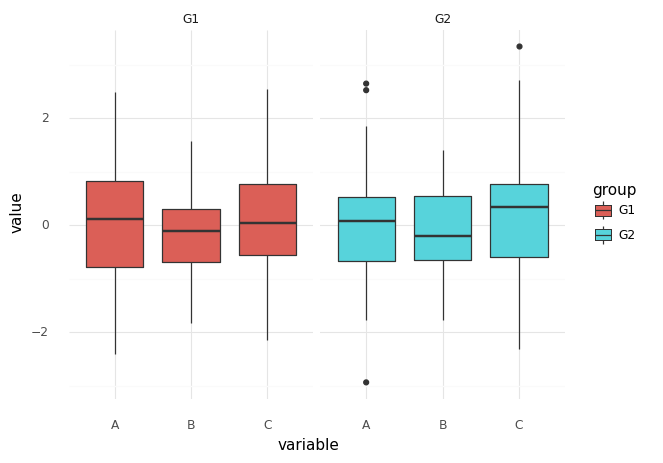

<ggplot: (334842766)>

In [18]:
(
    plotnine.ggplot(df_long, plotnine.aes(x='variable', y='value', fill='group'))
    + plotnine.geom_boxplot()
    + plotnine.facet_wrap('~group')
    + plotnine.theme_minimal()
)

### pandas-datareader

What fun is data science without data?

[pandas-datareader](https://github.com/pydata/pandas-datareader) gives you direct access to a diverse set of data sources.

In [19]:
import pandas_datareader as pdr

For example, [databases from Eurostat](https://ec.europa.eu/eurostat/data/database) are readily available:

In [20]:
# ilc_pw01: Average rating of satisfaction by domain, sex, age and educational attainment level
df_eurostat = pdr.data.DataReader('ilc_pw01', 'eurostat')
df_eurostat.T.head()

TIME_PERIOD                                                                                                                                      2018-01-01
ISCED11                                            UNIT          SEX     INDIC_WB                        AGE                 GEO         FREQ              
Less than primary, primary and lower secondary ... Rating (0-10) Females Satisfaction with accommodation From 16 to 24 years Austria     Annual         NaN
                                                                                                                             Belgium     Annual         NaN
                                                                                                                             Bulgaria    Annual         NaN
                                                                                                                             Switzerland Annual         NaN
                                                                                                                             Cyprus      Annual         NaN

In [21]:
df_eurostat.columns.get_level_values('SEX')

Index(['Females', 'Females', 'Females', 'Females', 'Females', 'Females',
       'Females', 'Females', 'Females', 'Females',
       ...
       'Total', 'Total', 'Total', 'Total', 'Total', 'Total', 'Total', 'Total',
       'Total', 'Total'],
      dtype='object', name='SEX', length=58050)

In [22]:
df_sub = (
    df_eurostat.T.xs('All ISCED 2011 levels', level='ISCED11')
    .xs('Total', level='SEX')
    .xs('Rating (0-10)', level='UNIT')
    .xs('Annual', level='FREQ')
    .reset_index()
    .drop('GEO', axis=1)
    .rename(
        columns={
            pd.Timestamp('2018-01-01 00:00:00'): 'satisfaction',
            'INDIC_WB': 'type',
            'AGE': 'age_range',
        }
    )
)
df_sub = df_sub[
    df_sub['age_range'].isin(
        [
            'From 16 to 24 years',
            'From 25 to 34 years',
            'From 35 to 49 years',
            'From 50 to 64 years',
            'From 65 to 74 years',
        ]
    )
]
df_sub.dropna().head()

TIME_PERIOD,type,age_range,satisfaction
774,Satisfaction with financial situation,From 16 to 24 years,7.7
775,Satisfaction with financial situation,From 16 to 24 years,7.1
776,Satisfaction with financial situation,From 16 to 24 years,4.1
777,Satisfaction with financial situation,From 16 to 24 years,7.1
778,Satisfaction with financial situation,From 16 to 24 years,6.4


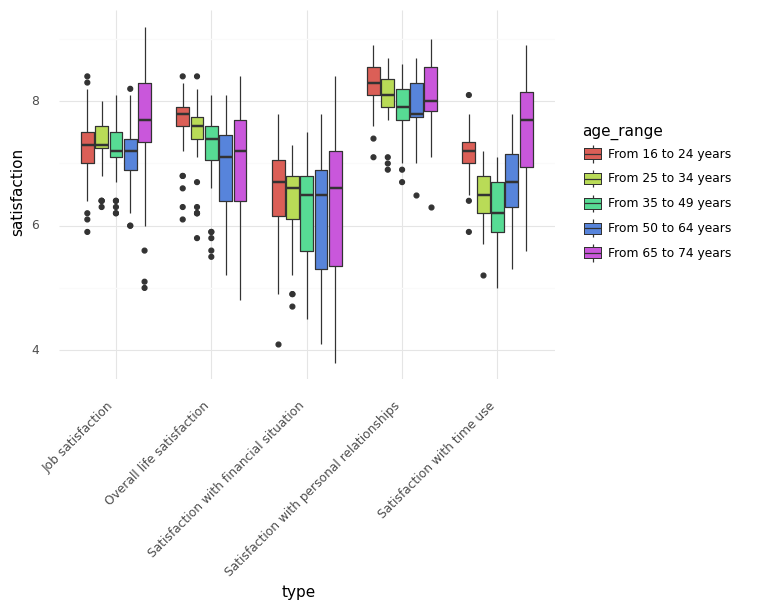

<ggplot: (334895665)>

In [23]:
(
    plotnine.ggplot(
        df_sub.dropna(), plotnine.aes(x='type', y='satisfaction', fill='age_range')
    )
    + plotnine.geom_boxplot()
    + plotnine.theme_minimal()
    + plotnine.theme(axis_text_x=plotnine.element_text(rotation=45, hjust=1))
)

### Networkx

[Networkx](https://github.com/networkx/networkx) is a wonderful library for conducting network analysis.

In [24]:
import networkx as nx

In [25]:
graph = nx.watts_strogatz_graph(100, 4, 0.1)
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 200
Average degree:   4.0000


In [26]:
pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='neato', args='-Goverlap=scale')
list(pos.items())[:3]

[(0, (2800.5, 870.29)), (1, (2479.1, 777.36)), (2, (2464.1, 408.03))]

In [27]:
node_clustering = nx.clustering(graph)
list(node_clustering.items())[:3]

[(0, 0.5), (1, 0.5), (2, 0.3333333333333333)]

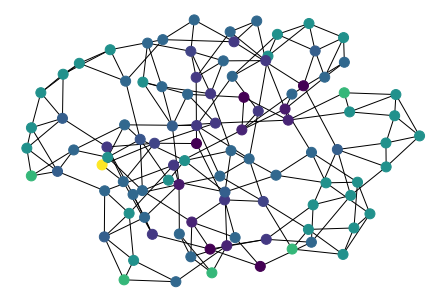

In [28]:
nx.draw(
    graph,
    pos,
    node_size=100,
    nodelist=list(node_clustering.keys()),
    node_color=list(node_clustering.values()),
)

### Plotting

#### Matplotlib

[Matplotlib](https://matplotlib.org/) is the de facto standard plotting library for Python.

In [29]:
import matplotlib.pyplot as plt

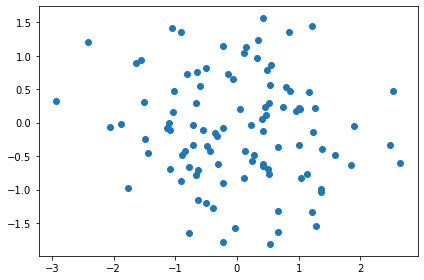

In [30]:
fig, ax = plt.subplots()

ax.scatter(data[:, 0], data[:, 1])

fig.tight_layout()

Axis ticks can be formatted in a multitude of different [ways](https://matplotlib.org/api/ticker_api.html#tick-formatting).
The most versatile way is probably `FuncFormatter`.

In [31]:
from matplotlib.ticker import FuncFormatter

In [32]:
@FuncFormatter
def my_formatter(x, pos):
    return f'{x=}, {pos=}'

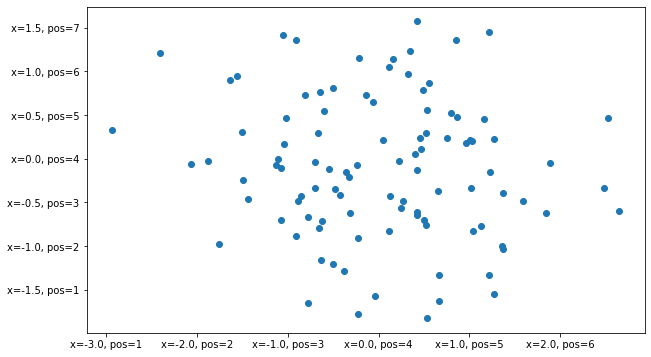

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(data[:, 0], data[:, 1])

ax.xaxis.set_major_formatter(my_formatter)
ax.yaxis.set_major_formatter(my_formatter)

#### Seaborn

[Seaborn](https://seaborn.pydata.org/) makes working with dataframes and creating commonly used plots accessible and comfortable.

In [34]:
import seaborn as sns

In [35]:
df_long.head()

,group,variable,value
0,G1,A,0.125915
1,G1,A,1.272522
2,G1,A,0.426671
3,G1,A,0.527546
4,G1,A,-1.441850


<AxesSubplot:xlabel='variable', ylabel='value'>

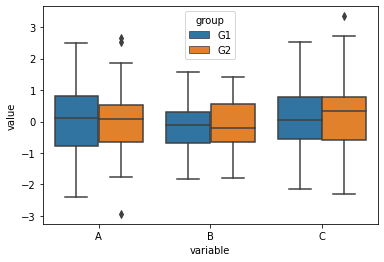

In [36]:
sns.boxplot(data=df_long, x='variable', y='value', hue='group')

#### Statannot

[Statannot](https://github.com/webermarcolivier/statannot) can be used to quickly add markers of significance to comparison plots.

In [37]:
import statannot

B_G1 v.s. B_G2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.415e-01 U_stat=1.207e+03


(<AxesSubplot:xlabel='variable', ylabel='value'>,
 [<statannot.StatResult.StatResult at 0x1401d3ca0>])

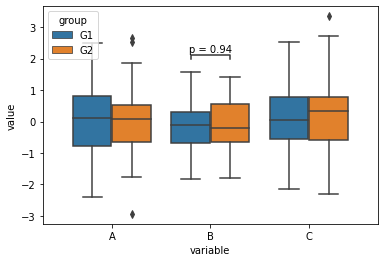

In [38]:
ax = sns.boxplot(
    data=df_long,
    x='variable',
    y='value',
    hue='group',
    order=['A', 'B', 'C'],
    hue_order=['G1', 'G2'],
)

statannot.add_stat_annotation(
    ax,
    plot='barplot',
    data=df_long,
    x='variable',
    y='value',
    hue='group',
    order=['A', 'B', 'C'],
    hue_order=['G1', 'G2'],
    box_pairs=[(('B', 'G1'), ('B', 'G2'))],
    text_format='simple',
    test='Mann-Whitney',
)

#### Brokenaxes

[Brokenaxes](https://github.com/bendichter/brokenaxes) can be used to include outliers in a plot without messing up the axis range. Note that this can be quite misleading.

In [39]:
import brokenaxes

[{'whiskers': [<matplotlib.lines.Line2D at 0x14037ba30>,
  'caps': [<matplotlib.lines.Line2D at 0x14038b730>,
  'boxes': [<matplotlib.lines.Line2D at 0x140385490>,
  'medians': [<matplotlib.lines.Line2D at 0x14038bdf0>,
  'fliers': [<matplotlib.lines.Line2D at 0x140399190>,
  'means': []},
 {'whiskers': [<matplotlib.lines.Line2D at 0x1403af040>,
  'caps': [<matplotlib.lines.Line2D at 0x1403af5b0>,
  'boxes': [<matplotlib.lines.Line2D at 0x1403a5ca0>,
  'medians': [<matplotlib.lines.Line2D at 0x1403afc70>,
  'fliers': [<matplotlib.lines.Line2D at 0x1403affd0>,
  'means': []}]

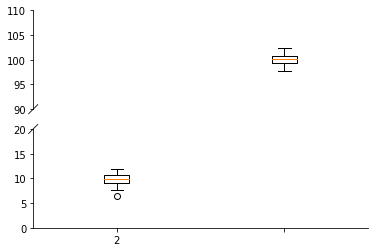

In [40]:
bax = brokenaxes.brokenaxes(ylims=((0, 20), (90, 110)))
bax.boxplot([np.random.normal(10, size=100), np.random.normal(100, size=100)])

#### Adjusttext

[Adjusttext](https://github.com/Phlya/adjustText) can help for plots with many labels which potentially overlap.

In [41]:
from adjustText import adjust_text

182

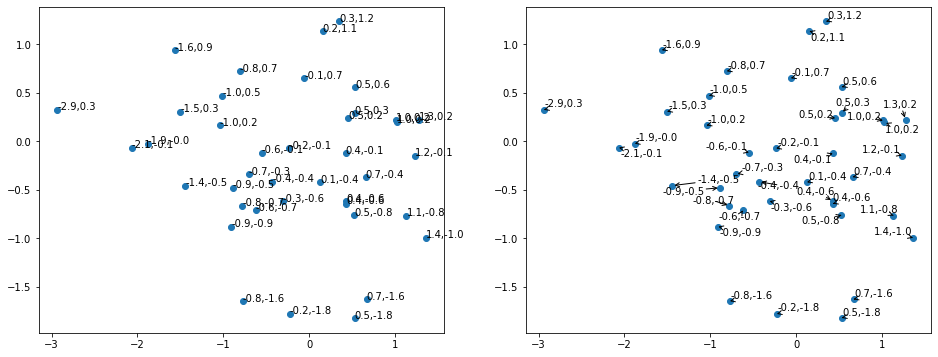

In [42]:
data_sub = data[:40, :]
fig, (ax_raw, ax_adj) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax_raw.scatter(data_sub[:, 0], data_sub[:, 1])
[
    ax_raw.annotate(f'{round(x, 1)},{round(y, 1)}', xy=(x, y))
    for x, y in data_sub[:, [0, 1]]
]

ax_adj.scatter(data_sub[:, 0], data_sub[:, 1])
adjust_text(
    [
        ax_adj.annotate(f'{round(x, 1)},{round(y, 1)}', xy=(x, y))
        for x, y in data_sub[:, [0, 1]]
    ],
    arrowprops=dict(arrowstyle='->'),
)

#### Folium

[Folium](https://github.com/python-visualization/folium) is a Python wrapper of the [Leaflet.js](https://leafletjs.com/) library to visualize dynamic maps.

In [43]:
import folium

In [44]:
folium.Map(
    location=[np.random.uniform(40, 70), np.random.uniform(10, 30)],
    zoom_start=7,
    width=500,
    height=500,
)

#### Ahlive

Creating animated visualizations becomes easy and fun with [ahlive](https://ahlive.readthedocs.io/en/latest/).

In [45]:
import ahlive as ah

[######                                  ] | 15% Completed |  1.0s

[######                                  ] | 15% Completed |  1.2s

[#######                                 ] | 17% Completed |  1.3s

[#######                                 ] | 17% Completed |  1.4s

[########                                ] | 20% Completed |  1.5s

[#########                               ] | 22% Completed |  1.6s

[#########                               ] | 22% Completed |  1.7s

[##########                              ] | 25% Completed |  1.8s

[###########                             ] | 27% Completed |  1.9s

[###########                             ] | 27% Completed |  2.0s

[############                            ] | 30% Completed |  2.1s

[#############                           ] | 32% Completed |  2.2s

[#############                           ] | 32% Completed |  2.3s

[##############                          ] | 35% Completed |  2.4s

[###############                         ] | 37% Completed |  2.5s

[###############                         ] | 37% Completed |  2.7s

[################                        ] | 40% Completed |  2.8s

[#################                       ] | 42% Completed |  2.9s

[##################                      ] | 45% Completed |  3.0s

[##################                      ] | 45% Completed |  3.1s

[###################                     ] | 47% Completed |  3.2s

[####################                    ] | 50% Completed |  3.3s

[####################                    ] | 50% Completed |  3.4s

[#####################                   ] | 52% Completed |  3.5s

[#####################                   ] | 52% Completed |  3.6s

[######################                  ] | 55% Completed |  3.7s

[#######################                 ] | 57% Completed |  3.9s

[#######################                 ] | 57% Completed |  4.0s

[########################                ] | 60% Completed |  4.1s

[#########################               ] | 62% Completed |  4.2s

[#########################               ] | 62% Completed |  4.3s

[##########################              ] | 65% Completed |  4.4s

[###########################             ] | 67% Completed |  4.5s

[###########################             ] | 67% Completed |  4.6s

[############################            ] | 70% Completed |  4.7s

[#############################           ] | 72% Completed |  4.8s

[##############################          ] | 75% Completed |  5.0s

[###############################         ] | 77% Completed |  5.1s

[###############################         ] | 77% Completed |  5.2s

[################################        ] | 80% Completed |  5.3s

[################################        ] | 80% Completed |  5.4s

[#################################       ] | 82% Completed |  5.5s

[##################################      ] | 85% Completed |  5.6s

[###################################     ] | 87% Completed |  5.7s

[###################################     ] | 87% Completed |  5.8s

[####################################    ] | 90% Completed |  6.0s

[#####################################   ] | 92% Completed |  6.1s

[######################################  ] | 95% Completed |  6.2s

[######################################  ] | 95% Completed |  6.3s

[####################################### ] | 97% Completed |  6.4s

[########################################] | 100% Completed |  6.5s


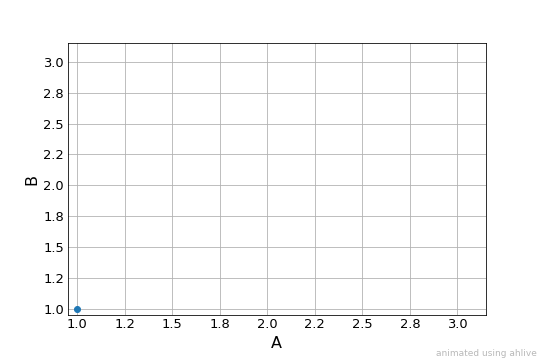

In [46]:
adf = ah.DataFrame(pd.DataFrame({'A': [1, 2, 3], 'B': [1, 2, 3]}), xs='A', ys='B')

adf.render()

#### Color palettes

Choosing the right color palette for your visualization can be tricky.
[palettable](https://github.com/jiffyclub/palettable) provides many useful ones.

In [47]:
import palettable

You can easily display a multitude of colorscales...

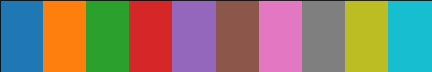

In [48]:
palettable.tableau.Tableau_10.show_discrete_image()

...and access them in a variety of ways.

In [49]:
print(palettable.tableau.Tableau_10.name)
print(palettable.tableau.Tableau_10.type)
print(palettable.tableau.Tableau_10.hex_colors)
print(palettable.tableau.Tableau_10.mpl_colormap)

Tableau_10
qualitative
['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']


### High performance

When dealing with large amounts of data or many computations, it can make sense to optimize hotspots in C++ or use specialized libraries.

#### Dask

[Dask](https://github.com/dask/dask) provides a Panda's like interface to high-performance dataframes which support out-of-memory processing, cluster distribution, and more.
It is particularly useful when the dataframe does not fit in RAM anymore. Common operations operate on chunks of the dataframe and are only executed when explicitly requested.

In [50]:
import dask.dataframe as dd

In [51]:
df = pd.DataFrame(np.random.normal(size=(1_000_000, 2)), columns=['A', 'B'])

In [52]:
ddf = dd.from_pandas(df, npartitions=4)
ddf.head()

,A,B
0,1.209945,-0.829657
1,-1.041410,0.138946
2,0.497872,0.628439
3,-0.418077,0.039312
4,-0.353732,0.500529


In [53]:
ddf['A'] + ddf['B']

Dask Series Structure:
npartitions=4
0         float64
250000        ...
500000        ...
750000        ...
999999        ...
dtype: float64
Dask Name: add, 16 tasks

In [54]:
(ddf['A'] + ddf['B']).compute()

0         0.380288
1        -0.902464
2         1.126310
3        -0.378765
4         0.146798
            ...   
999995   -1.198871
999996    0.195255
999997    1.707589
999998   -1.505217
999999   -1.828147
Length: 1000000, dtype: float64

#### Vaex

[Vaex](https://github.com/vaexio/vaex) fills a similar niche as dask and makes working with out-of-core dataframe easy.
It has a slightly more intuitive interface and offers many cool visualizations right out of the box.

In [55]:
import vaex as vx

In [56]:
vdf = vx.from_pandas(df)
vdf.head()

#,A,B
0,1.20994,-0.829657
1,-1.04141,0.138946
2,0.497872,0.628439
3,-0.418077,0.0393116
4,-0.353732,0.500529
5,0.218921,-0.140769
6,1.44677,0.177711
7,-0.929196,-0.306118
8,1.23181,1.37377
9,-0.354355,-1.17795


In [57]:
vdf['A'] + vdf['B']

Expression = (A + B)
Length: 1,000,000 dtype: float64 (expression)
---------------------------------------------
     0   0.380288
     1  -0.902464
     2    1.12631
     3  -0.378765
     4   0.146798
       ...       
999995   -1.19887
999996   0.195255
999997    1.70759
999998   -1.50522
999999   -1.82815

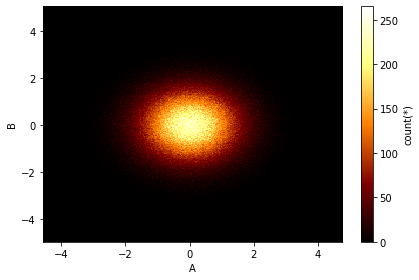

In [58]:
vdf.plot(vdf['A'], vdf['B'])

#### Joblib

[Joblib](https://github.com/joblib/joblib) makes executing functions in parallel very easy and removes boilerplate code.

In [59]:
import time
import random

import joblib

In [60]:
def heavy_function(i):
    print(f'{i=}')
    time.sleep(random.random())
    return i ** i

In [61]:
joblib.Parallel(n_jobs=2)([joblib.delayed(heavy_function)(i) for i in range(10)])

[1, 1, 4, 27, 256, 3125, 46656, 823543, 16777216, 387420489]

#### Swifter

Choosing the correct way of parallelizing your computations can be non-trivial. [Swifter](https://github.com/jmcarpenter2/swifter) tries to automatically select the most suitable one.

In [62]:
import swifter

In [63]:
df_big = pd.DataFrame({'A': np.random.randint(0, 100, size=1_000_000)})
df_big.head()

,A
0,29
1,84
2,61
3,63
4,39


In [64]:
%%timeit
df_big['A'].apply(lambda x: x ** 2)

526 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%%timeit
df_big['A'].swifter.apply(lambda x: x ** 2)

2.84 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Bioinformatics

#### PyRanges

[PyRanges](https://github.com/biocore-ntnu/pyranges) makes working with genomic ranges easy as pie.

In [66]:
import pyranges as pr

In [67]:
df_exons = pr.data.exons()
df_exons

+--------------+-----------+-----------+-------+
| Chromosome   | Start     | End       | +3    |
| (category)   | (int32)   | (int32)   | ...   |
|--------------+-----------+-----------+-------|
| chrX         | 135721701 | 135721963 | ...   |
| chrX         | 135574120 | 135574598 | ...   |
| chrX         | 47868945  | 47869126  | ...   |
| chrX         | 77294333  | 77294480  | ...   |
| ...          | ...       | ...       | ...   |
| chrY         | 15409586  | 15409728  | ...   |
| chrY         | 15478146  | 15478273  | ...   |
| chrY         | 15360258  | 15361762  | ...   |
| chrY         | 15467254  | 15467278  | ...   |
+--------------+-----------+-----------+-------+
Stranded PyRanges object has 1,000 rows and 6 columns from 2 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
3 hidden columns: Name, Score, Strand

In [68]:
df_locus = pr.PyRanges(
    pd.DataFrame({'Chromosome': ['chrX'], 'Start': [1_400_000], 'End': [1_500_000]})
)
df_locus

+--------------+-----------+-----------+
| Chromosome   |     Start |       End |
| (category)   |   (int32) |   (int32) |
|--------------+-----------+-----------|
| chrX         |   1400000 |   1500000 |
+--------------+-----------+-----------+
Unstranded PyRanges object has 1 rows and 3 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

In [69]:
df_exons.overlap(df_locus).df

,Chromosome,Start,End,Name,Score,Strand
0,chrX,1475113,1475229,NM_001267713_exon_4_0_chrX_1475114_f,0,+
1,chrX,1419383,1419519,NM_001161531_exon_9_0_chrX_1419384_f,0,+
2,chrX,1424338,1424420,NM_006140_exon_11_0_chrX_1424339_f,0,+
3,chrX,1407651,1407781,NM_001161532_exon_3_0_chrX_1407652_f,0,+
4,chrX,1404670,1404813,NM_172245_exon_3_0_chrX_1404671_f,0,+
5,chrX,1424338,1424420,NM_001161530_exon_10_0_chrX_1424339_f,0,+
6,chrX,1414319,1414349,NM_172245_exon_8_0_chrX_1414320_f,0,+
7,chrX,1407411,1407535,NM_172249_exon_4_0_chrX_1407412_f,0,+


#### Obonet

[Obonet](https://github.com/dhimmel/obonet) is a library for working with (OBO-formatted) ontologies.

In [70]:
import obonet

In [71]:
url = 'https://github.com/DiseaseOntology/HumanDiseaseOntology/raw/main/src/ontology/HumanDO.obo'
graph = obonet.read_obo(url)

In [72]:
list(graph.nodes(data=True))[0]

('DOID:0001816',
 {'name': 'angiosarcoma',
  'alt_id': ['DOID:267', 'DOID:4508'],
  'def': '"A vascular cancer that derives_from the cells that line the walls of blood vessels or lymphatic vessels." [url:http\\://en.wikipedia.org/wiki/Hemangiosarcoma, url:https\\://en.wikipedia.org/wiki/Angiosarcoma, url:https\\://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C3088, url:https\\://www.ncbi.nlm.nih.gov/pubmed/23327728]',
  'subset': ['DO_cancer_slim', 'NCIthesaurus'],
  'synonym': ['"hemangiosarcoma" EXACT []'],
  'xref': ['ICDO:9120/3',
   'MESH:D006394',
   'NCI:C3088',
   'NCI:C9275',
   'SNOMEDCT_US_2020_09_01:39000009',
   'UMLS_CUI:C0018923',
   'UMLS_CUI:C0854893'],
  'is_a': ['DOID:175']})

### Statistics/Machine Learning

#### Statsmodels

[Statsmodels](https://github.com/statsmodels/statsmodels) helps with statistical modelling.

In [73]:
import statsmodels.formula.api as smf

In [74]:
df_data = pd.DataFrame({'X': np.random.normal(size=100)})

df_data['Y'] = 1.3 * df_data['X'] + 4.2

df_data.head()

,X,Y
0,0.927521,5.405777
1,2.110368,6.943479
2,1.517580,6.172854
3,-0.069583,4.109542
4,-0.644390,3.362293


In [75]:
mod = smf.ols('Y ~ X', data=df_data)
res = mod.fit()

In [76]:
res.params

Intercept    4.2
X            1.3
dtype: float64

In [77]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.2000,2.03e-16,2.07e+16,0.000,4.200,4.200
X,1.3000,1.93e-16,6.73e+15,0.000,1.300,1.300


#### Pingouin

[Pingouin](https://github.com/raphaelvallat/pingouin) provides additional statistical methods.

In [78]:
import pingouin as pg

In [79]:
pg.normality(np.random.normal(size=100))

/Users/kimja/.pyenv/versions/3.8.6/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
/Users/kimja/.pyenv/versions/3.8.6/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


,W,pval,normal
0,0.985349,0.336443,True


In [80]:
pg.normality(np.random.uniform(size=100))

,W,pval,normal
0,0.946713,0.000507,False


#### Scitkit-learn

[Scikit-learn](https://github.com/scikit-learn/scikit-learn) facilitates machine learning in Python.

In [81]:
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [82]:
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [84]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

Scikit-learn offers various plugins which deal with common issues encountered while modeling.

[Imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) provides various re-sampling techniques when the dataset has annoying class imbalances.

In [85]:
import collections

from imblearn.over_sampling import RandomOverSampler

In [86]:
ros = RandomOverSampler(random_state=0)

In [87]:
X_sub, y_sub = X[:60, :], y[:60]
X_resampled, y_resampled = ros.fit_resample(X_sub, y_sub)

In [88]:
print('sub:', sorted(collections.Counter(y_sub).items()))
print('resampled:', sorted(collections.Counter(y_resampled).items()))

sub: [(0, 50), (1, 10)]
resampled: [(0, 50), (1, 50)]


[Category_encoders](https://github.com/scikit-learn-contrib/category_encoders) helps with converting categorical variables to numerical ones.

In [89]:
import category_encoders

In [90]:
tmp = np.random.choice(['A', 'B'], size=10)
df_cat = pd.DataFrame({'original_class': tmp, 'feature01': tmp})
df_cat.head()

,original_class,feature01
0,A,A
1,B,B
2,A,A
3,A,A
4,B,B


In [91]:
category_encoders.OneHotEncoder(cols=['feature01']).fit_transform(df_cat)

,original_class,feature01_1,feature01_2
0,A,1,0
1,B,0,1
2,A,1,0
3,A,1,0
4,B,0,1
5,B,0,1
6,B,0,1
7,B,0,1
8,B,0,1
9,B,0,1


[Yellowbrick](https://github.com/DistrictDataLabs/yellowbrick) makes a multitude of visual diagnostic tools readily accessible.

In [92]:
from yellowbrick.classifier import ROCAUC

In [93]:
clf.fit(X, y)

SVC(C=1, kernel='linear')

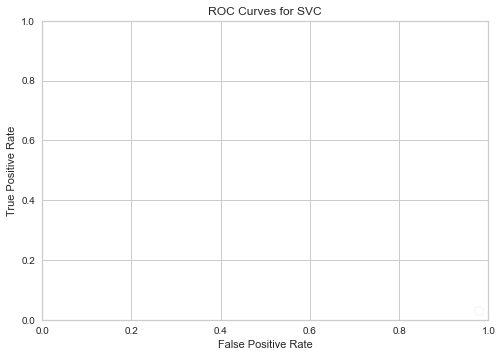

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [94]:
visualizer = ROCAUC(clf)
# visualizer.score(X, y)  # TODO: uncomment once scikit-learn is fixed
visualizer.show()

## Language Bindings

### Pybind11

[Pybind11](https://github.com/pybind/pybind11) makes writing bindings between Python and C++ enjoyable. In combination with [cppimport](https://github.com/tbenthompson/cppimport) some might even call it fun.
It is possible to implement [custom typecasters](https://pybind11.readthedocs.io/en/stable/advanced/cast/custom.html) to support bindings for arbitrary objects.

In [95]:
%%writefile cpp_source.cpp

#include <pybind11/pybind11.h>

namespace py = pybind11;


int square(int x) {
    return x * x;
}

PYBIND11_MODULE(cpp_source, m) {
    m.def(
        "square", &square,
        py::arg("x") = 1
    );
}

/*
<%
setup_pybind11(cfg)
cfg['compiler_args'] = ['-std=c++11']
%>
*/

Overwriting cpp_source.cpp


In [96]:
import cppimport

In [97]:
cpp_source = cppimport.imp('cpp_source')

In [98]:
cpp_source.square(5)

25

## Jupyter

### Nbstripout

Commiting Jupyter notebooks to CVS (e.g. git) can be annoying due to non-code properties being saved.
[Nbstripout](https://github.com/kynan/nbstripout) strips all of those away and can be run automatically for each committed notebook by executing `nbstripout --install` once.

## Miscellaneous

### humanize

[humanize](https://github.com/jmoiron/humanize) allows to format numbers with the goal of making them more human-readable.

In [99]:
import datetime

import humanize

This is, of course, highly context-dependent:

In [100]:
big_number = 4578934

print('Actual number:', big_number)
print('Readable number:', humanize.intword(big_number))
print('Time difference:', humanize.precisedelta(datetime.timedelta(seconds=big_number)))
print('File size:', humanize.naturalsize(big_number))

Actual number: 4578934
Readable number: 4.6 million
Time difference: 1 month, 21 days, 23 hours, 55 minutes and 34 seconds
File size: 4.6 MB


### rich

Making sure that terminal applications have nicely formatted output makes using them a much better experience.

[rich](https://github.com/willmcgugan/rich) makes it easy to add colors and other fluff.

In [101]:
import rich

In [102]:
rich.print('[green]Hello[/green] [bold red]World[/bold red] :tada:')

Hello World 🎉

It is also useful in the everyday life of a Python developer:

In [103]:
rich.inspect(rich.print)

╭──────────────────────────── <function print at 0x14c517d30> ────────────────────────────╮
│ def print(*objects: Any, sep=' ', end='\n', file: IO[str] = None, flush: bool = False): │
│                                                                                         │
│ Print object(s) supplied via positional arguments.                                      │
│ This function has an identical signature to the built-in print.                         │
│ For more advanced features, see the :class:`~rich.console.Console` class.               │
│                                                                                         │
│ 35 attribute(s) not shown. Run inspect(inspect) for options.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────╯

## ToDo

* Validate your config files using [schemas](https://github.com/Julian/jsonschema/).
* Design your pipelines using [Snakemake](https://bitbucket.org/snakemake/snakemake).
* moviepy
* https://github.com/tqdm/tqdm
* https://github.com/pyca/cryptography
* numba
* pythran
* https://github.com/cloudpipe/cloudpickle
* jupytext
* tensorflow
* filprofiler
* https://github.com/mitmproxy/mitmproxy
* https://github.com/secdev/scapy
* https://github.com/emeryberger/scalene
* https://github.com/joerick/pyinstrument